In [1]:
## First we'll need to setup our environment with the necessary imports

# Basic imports
import numpy as np 
import pandas as pd
import os
from os import path

# Viz imports
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLP imports
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

from string import punctuation
import re,string,unicodedata

# Model imports
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

# Neural Net imports
import keras
from keras.layers import Dense,LSTM
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
df = pd.read_csv("Musical_instruments_reviews.csv")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [3]:
df.shape

(10261, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


In [5]:
df.isna().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

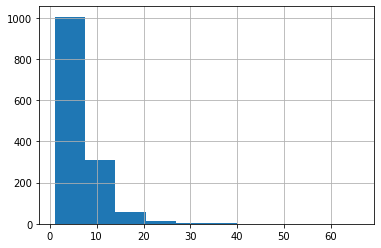

In [6]:
df.reviewerName.value_counts().hist()

In [7]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [8]:
# Create a full picture of all the relevant text associated with each review
df['full_review'] = df['reviewText'] + ' ' + df['summary']

# Create a feature that gives us a length of each review
df['review_length']  = df['full_review'].str.len()

# Drop columns we won't be using
df.drop(['reviewText', 'reviewerID', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewTime'], axis=1, inplace=True)

# Fix the naming convention for each of the remaining columns
df = df.rename(columns={"asin": "product_id", 'overall':'rating'})

# Drop rows with missing values
df = df.dropna()

df.head()

,product_id,rating,summary,full_review,review_length
0,1384719342,5.0,good,"Not much to write about here, but it does exac...",273.0
1,1384719342,5.0,Jake,The product does exactly as it should and is q...,549.0
2,1384719342,5.0,It Does The Job Well,The primary job of this device is to block the...,457.0
3,1384719342,5.0,GOOD WINDSCREEN FOR THE MONEY,Nice windscreen protects my MXL mic and preven...,236.0
4,1384719342,5.0,No more pops when I record my vocals.,This pop filter is great. It looks and perform...,197.0


## Exploration and Visualization

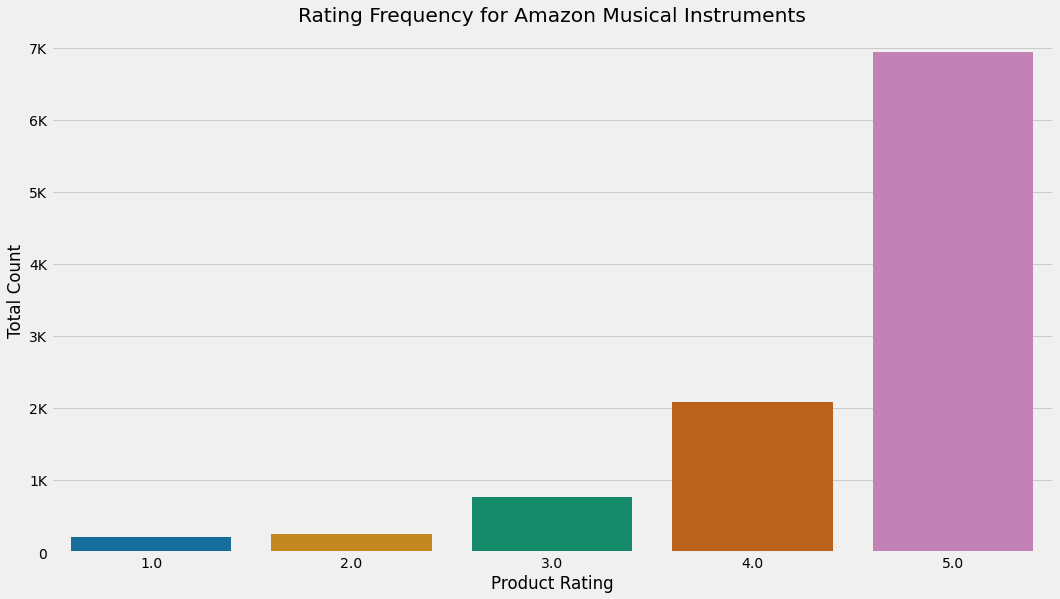

In [9]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16, 9))
sns.countplot(df['rating'], data=df, palette='colorblind')
plt.title('Rating Frequency for Amazon Musical Instruments')
plt.yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000], ['0', '1K', '2K', '3K', '4K', '5K', '6K', '7K'])
plt.ylabel('Total Count')
plt.xlabel('Product Rating')
plt.show()

In [25]:
top_20.sum()/df.shape[0]

0.1520382289838112

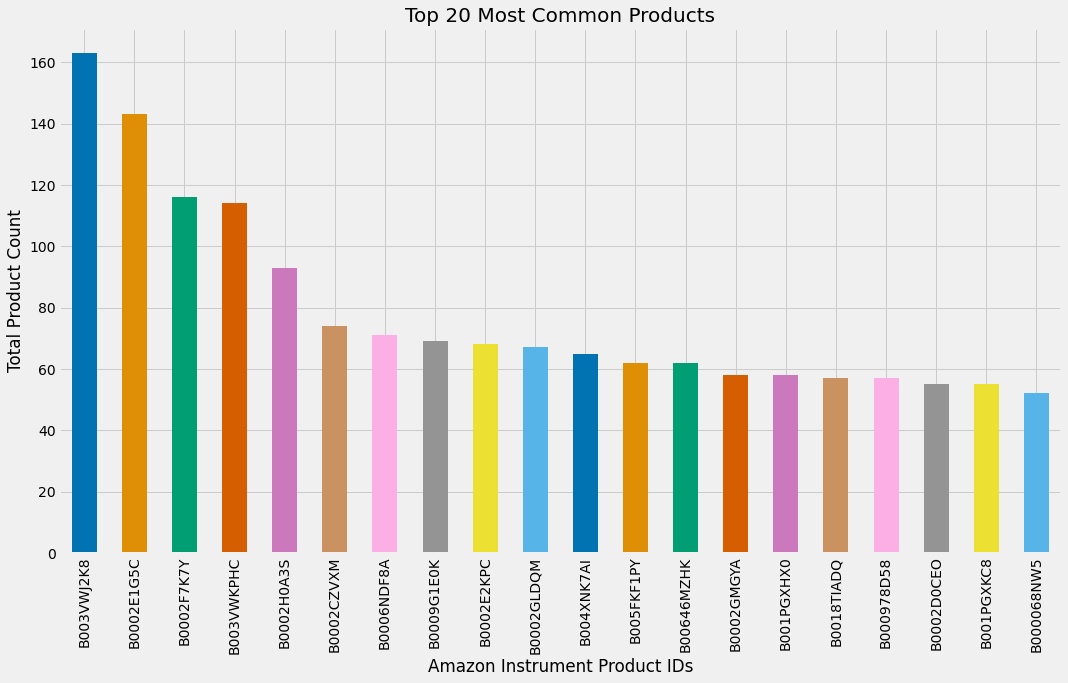

In [10]:
# Create a pandas series of the Top 20 Most Common Products
top_20 = df['product_id'].value_counts()[:20]

color_pal = sns.color_palette("colorblind")
plt.figure(figsize=(16, 9))
top_20 = df['product_id'].value_counts()[:20]
top_20.plot.bar(color=color_pal)
plt.title('Top 20 Most Common Products', fontsize = 20)
plt.xlabel('Amazon Instrument Product IDs')
plt.ylabel('Total Product Count')
plt.show()

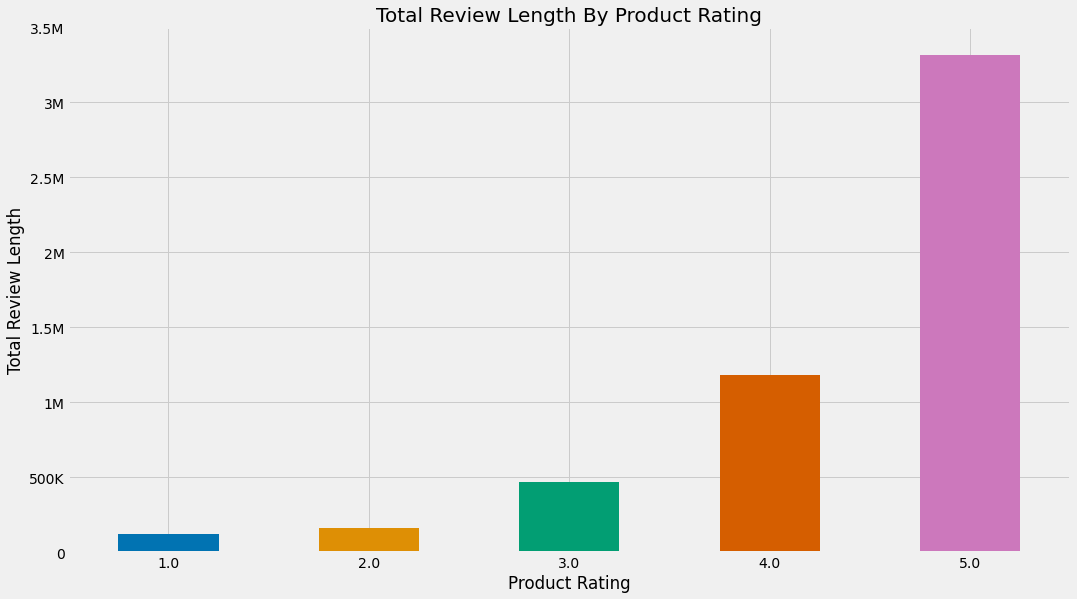

In [11]:
# 
df_review_length = df.groupby(['rating'])['review_length'].sum()

plt.figure(figsize=(16, 9))
color_pal = sns.color_palette("colorblind")

df_review_length.plot.bar(color=color_pal, rot=0)

plt.title('Total Review Length By Product Rating', fontsize = 20)
plt.xlabel('Product Rating')
plt.yticks([0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000], ['0', '500K', '1M', '1.5M', '2M', '2.5M', '3M', '3.5M'])
plt.ylabel('Total Review Length')

plt.show()

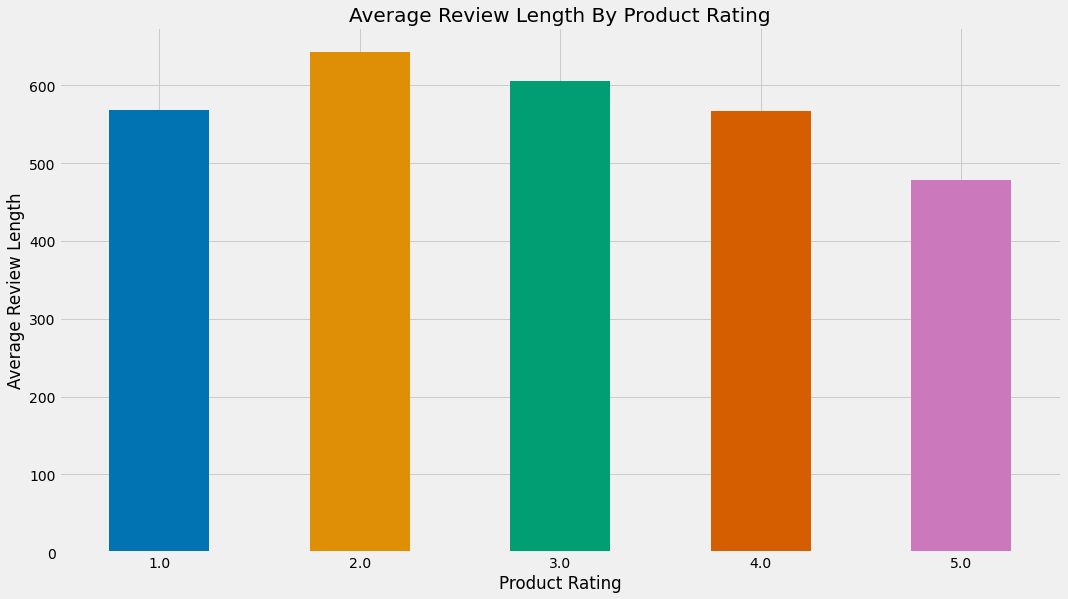

In [12]:
df_review_length = df.groupby(['rating'])['review_length'].mean()

plt.figure(figsize=(16, 9))
color_pal = sns.color_palette("colorblind")

df_review_length.plot.bar(color=color_pal, rot=0)

plt.title('Average Review Length By Product Rating', fontsize = 20)
plt.xlabel('Product Rating')
plt.ylabel('Average Review Length')

plt.show()

## NLP Processing and Modeling

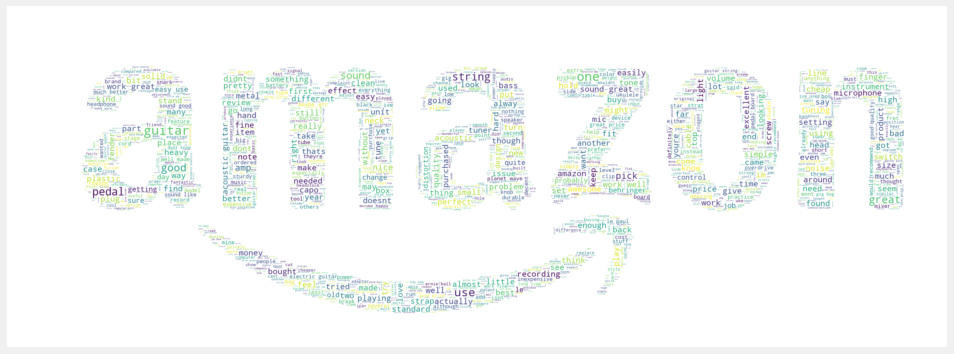

<Figure size 1080x504 with 0 Axes>

In [27]:
def clean(text: str) -> list:
    'A simple function to cleanup text data'
    
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (text.encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # tokenization
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

corpus = clean(' '.join(df.full_review))

def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 

#w = corpus

corpus_str = listToString(corpus)

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
#text = ham_str

# read the mask / color image taken from
# http://jirkavinse.deviantart.com/art/quot-Real-Life-quot-Alice-282261010
coloring = np.array(Image.open(path.join(d, "Amazon-logo.jpg")))
stopwords = set(STOPWORDS)
#stopwords.add("said")

wc = WordCloud(background_color="white", max_words=2000, mask=coloring,
               stopwords=stopwords, max_font_size=40, random_state=42)
# generate word cloud
wc.generate(corpus_str)

# create coloring from image
image_colors = ImageColorGenerator(coloring)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.show()

## Modeling

In [29]:
df.head()

,product_id,rating,summary,full_review,review_length
0,1384719342,5.0,good,"Not much to write about here, but it does exac...",273.0
1,1384719342,5.0,Jake,The product does exactly as it should and is q...,549.0
2,1384719342,5.0,It Does The Job Well,The primary job of this device is to block the...,457.0
3,1384719342,5.0,GOOD WINDSCREEN FOR THE MONEY,Nice windscreen protects my MXL mic and preven...,236.0
4,1384719342,5.0,No more pops when I record my vocals.,This pop filter is great. It looks and perform...,197.0


In [30]:
df.rating.value_counts()

5.0    6932
4.0    2083
3.0     772
2.0     250
1.0     217
Name: rating, dtype: int64

In [31]:
# Let's make a binary sentiment encoder

def sentiment(rating):
    # Replacing ratings of 1,2,3 with 0 (not good) and 4,5 with 1 (good)
    if(int(rating) == 1 or int(rating) == 2 or int(rating) == 3):
        return 0
    else: 
        return 1
    
# Add a new column to the dataframe with this encoded sentiment
df['rating_sentiment'] = df.rating.apply(sentiment) 

In [32]:
df.rating_sentiment.value_counts()

1    9015
0    1239
Name: rating_sentiment, dtype: int64

In [33]:
def basic_clean(df, col):
    '''
    This function takes in a df and a string for a column and
    returns the df with a new column named 'basic_clean' with the
    passed column text normalized.
    '''
    df['basic_clean'] = df[col].str.lower()\
                    .replace(r'[^\w\s]', '', regex=True)\
                    .str.normalize('NFKC')\
                    .str.encode('ascii', 'ignore')\
                    .str.decode('utf-8', 'ignore')
    return df

def tokenize(df, col):
    '''
    This function takes in a df and a string for a column and
    returns a df with a new column named 'clean_tokes' with the
    passed column text tokenized and in a list.
    '''
    tokenizer = nltk.tokenize.ToktokTokenizer()
    df['clean_tokes'] = df[col].apply(tokenizer.tokenize)
    return df

def stem(df, col):
    '''
    This function takes in a df and a string for a column name and
    returns a df with a new column named 'stemmed'.
    '''
    # Create porter stemmer
    ps = nltk.porter.PorterStemmer()
    
    # Stem each token from our clean_tokes Series of lists
    stems = df[col].apply(lambda row: [ps.stem(word) for word in row])
    
    # Join our cleaned, stemmed lists of words back into sentences
    df['stemmed'] = stems.str.join(' ')
    
    return df

def lemmatize(df, col):
    '''
    This function takes in a df and a string for column name and
    returns the original df with a new column called 'lemmatized'.
    '''
    # Create the lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Lemmatize each token from our clean_tokes Series of lists
    lemmas = df[col].apply(lambda row: [wnl.lemmatize(word) for word in row])
    
    # Join the cleaned and lemmatized tokens back into sentences
    df['lemmatized'] = lemmas.str.join(' ')
    return df

def remove_stopwords(df, col):
    '''
    This function takes in a df and a string for column name and 
    returns the df with a new column named 'clean' with stopwords removed.
    '''
    # Create stopword_list
    stopword_list = nltk.corpus.stopwords.words('english')
    stopword_list.extend('&#9;')
    
    # Split words in column
    words = df[col].str.split()
    
    # Check each word in each row of the column against stopword_list and return only those that are not in list
    filtered_words = words.apply(lambda row: [word for word in row if word not in stopword_list])
    
    # Create new column of words that have stopwords removed
    df['clean_' + col] = filtered_words.str.join(' ')
    
    return df

def prep_repo_data(df):
    '''
    This function takes in the github repo df and
    returns the df with original columns plus cleaned
    and lemmatized content without stopwords.
    '''

    # Do basic clean on repo content
    df = basic_clean(df, 'full_review')
    
    # Tokenize clean content
    df = tokenize(df, 'basic_clean')
    
    # Stem cleaned and tokenized content
    df = stem(df, 'clean_tokes')
    
    
    # Lemmatize cleaned and tokenized content
    df = lemmatize(df, 'clean_tokes')
    
    # Remove stopwords from Lemmatized content
    df = remove_stopwords(df, 'lemmatized')
    
    return df

In [34]:
prep_repo_data(df)

,product_id,rating,summary,full_review,review_length,rating_sentiment,basic_clean,clean_tokes,stemmed,lemmatized,clean_lemmatized
0,1384719342,5.0,good,"Not much to write about here, but it does exac...",273.0,1,not much to write about here but it does exact...,"[not, much, to, write, about, here, but, it, d...",not much to write about here but it doe exactl...,not much to write about here but it doe exactl...,much write doe exactly supposed filter pop sou...
1,1384719342,5.0,Jake,The product does exactly as it should and is q...,549.0,1,the product does exactly as it should and is q...,"[the, product, does, exactly, as, it, should, ...",the product doe exactli as it should and is qu...,the product doe exactly a it should and is qui...,product doe exactly quite affordablei realized...
2,1384719342,5.0,It Does The Job Well,The primary job of this device is to block the...,457.0,1,the primary job of this device is to block the...,"[the, primary, job, of, this, device, is, to, ...",the primari job of thi devic is to block the b...,the primary job of this device is to block the...,primary job device block breath would otherwis...
3,1384719342,5.0,GOOD WINDSCREEN FOR THE MONEY,Nice windscreen protects my MXL mic and preven...,236.0,1,nice windscreen protects my mxl mic and preven...,"[nice, windscreen, protects, my, mxl, mic, and...",nice windscreen protect my mxl mic and prevent...,nice windscreen protects my mxl mic and preven...,nice windscreen protects mxl mic prevents pop ...
4,1384719342,5.0,No more pops when I record my vocals.,This pop filter is great. It looks and perform...,197.0,1,this pop filter is great it looks and performs...,"[this, pop, filter, is, great, it, looks, and,...",thi pop filter is great it look and perform li...,this pop filter is great it look and performs ...,pop filter great look performs like studio fil...
...,...,...,...,...,...,...,...,...,...,...,...
10256,B00JBIVXGC,5.0,Five Stars,"Great, just as expected. Thank to all. Five S...",50.0,1,great just as expected thank to all five stars,"[great, just, as, expected, thank, to, all, fi...",great just as expect thank to all five star,great just a expected thank to all five star,great expected thank five star
10257,B00JBIVXGC,5.0,"Long life, and for some players, a good econom...",I've been thinking about trying the Nanoweb st...,3088.0,1,ive been thinking about trying the nanoweb str...,"[ive, been, thinking, about, trying, the, nano...",ive been think about tri the nanoweb string fo...,ive been thinking about trying the nanoweb str...,ive thinking trying nanoweb string wa bit put ...
10258,B00JBIVXGC,4.0,Good for coated.,I have tried coated strings in the past ( incl...,636.0,1,i have tried coated strings in the past inclu...,"[i, have, tried, coated, strings, in, the, pas...",i have tri coat string in the past includ elix...,i have tried coated string in the past includi...,tried coated string past including elixir neve...
10259,B00JBIVXGC,4.0,Taylor Made,"Well, MADE by Elixir and DEVELOPED with Taylor...",1656.0,1,well made by elixir and developed with taylor ...,"[well, made, by, elixir, and, developed, with,...",well made by elixir and develop with taylor gu...,well made by elixir and developed with taylor ...,well made elixir developed taylor guitar strin...


In [36]:
df.head()

,product_id,rating,summary,full_review,review_length,rating_sentiment,basic_clean,clean_tokes,stemmed,lemmatized,clean_lemmatized
0,1384719342,5.0,good,"Not much to write about here, but it does exac...",273.0,1,not much to write about here but it does exact...,"[not, much, to, write, about, here, but, it, d...",not much to write about here but it doe exactl...,not much to write about here but it doe exactl...,much write doe exactly supposed filter pop sou...
1,1384719342,5.0,Jake,The product does exactly as it should and is q...,549.0,1,the product does exactly as it should and is q...,"[the, product, does, exactly, as, it, should, ...",the product doe exactli as it should and is qu...,the product doe exactly a it should and is qui...,product doe exactly quite affordablei realized...
2,1384719342,5.0,It Does The Job Well,The primary job of this device is to block the...,457.0,1,the primary job of this device is to block the...,"[the, primary, job, of, this, device, is, to, ...",the primari job of thi devic is to block the b...,the primary job of this device is to block the...,primary job device block breath would otherwis...
3,1384719342,5.0,GOOD WINDSCREEN FOR THE MONEY,Nice windscreen protects my MXL mic and preven...,236.0,1,nice windscreen protects my mxl mic and preven...,"[nice, windscreen, protects, my, mxl, mic, and...",nice windscreen protect my mxl mic and prevent...,nice windscreen protects my mxl mic and preven...,nice windscreen protects mxl mic prevents pop ...
4,1384719342,5.0,No more pops when I record my vocals.,This pop filter is great. It looks and perform...,197.0,1,this pop filter is great it looks and performs...,"[this, pop, filter, is, great, it, looks, and,...",thi pop filter is great it look and perform li...,this pop filter is great it look and performs ...,pop filter great look performs like studio fil...


In [ ]:
documents = df[['rating', 'clean_lemmatized']]

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(documents.clean_lemmatized)
y = documents.language

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        train_size=.8, stratify=y, random_state=42)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

model = LogisticRegression().fit(X_train, y_train)
model = DecisionTreeClassifier(max_depth=12, random_state=42).fit(X_train, y_train)
model = RandomForestClassifier(max_depth=12, min_samples_leaf=1, random_state=42).fit(X_train, y_train)
model = KNeighborsClassifier(n_neighbors=15).fit(X_train, y_train)

train['predicted'] = model.predict(X_train)
test['predicted'] = model.predict(X_test)

print(round(model.score(X_train, y_train), 4))
print(round(model.score(X_test, y_test), 4))

In [ ]:
X = df.clean_lemmatized
y = df.rating_sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8,stratify=y, random_state=19)

In [ ]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(X_train)
#transformed test reviews
cv_test_reviews=cv.transform(X_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

In [ ]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(X_train)
#transformed test reviews
tv_test_reviews=tv.transform(X_test)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

In [ ]:
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=0)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,y_train)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,y_train)
print(lr_tfidf)

In [ ]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)

In [ ]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(y_test,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(y_test,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

In [ ]:
#Classification report for bag of words
lr_bow_report=classification_report(y_test,lr_bow_predict,target_names=['0','1'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(y_test,lr_tfidf_predict,target_names=['0','1'])
print(lr_tfidf_report)

In [ ]:
#training the model
mnb=MultinomialNB()
#fitting the nb for bag of words
mnb_bow=mnb.fit(cv_train_reviews,y_train)
print(mnb_bow)
#fitting the nb for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,y_train)
print(mnb_tfidf)

In [ ]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)

In [ ]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(y_test,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(y_test,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

In [ ]:
mnb_bow_report = classification_report(y_test,mnb_bow_predict,target_names = ['0','1'])
print(mnb_bow_report)
mnb_tfidf_report = classification_report(y_test,mnb_tfidf_predict,target_names = ['0','1'])
print(mnb_tfidf_report)

In [ ]:
model = Sequential()
model.add(Dense(units = 75 , activation = 'relu' , input_dim = cv_train_reviews.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu')) 
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(cv_train_reviews,y_train , epochs = 4)

In [ ]:
model.evaluate(cv_test_reviews,y_test)[1]